In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df_main = pd.read_csv('Data/processed/main_dataset_clean.csv')
    user_metrics = pd.read_csv('Data/processed/user_metrics_aggregated.csv')
    print("DataFrame fue cargado exitosamente.")
except FileNotFoundError:
    print("Error: El archivo no se encontr√≥. Aseg√∫rate de haberlo guardado en la carpeta correcta.")

DataFrame fue cargado exitosamente.


In [4]:
print(f"\nColumnas disponibles en user_metrics:")
print(user_metrics.columns.tolist())


Columnas disponibles en user_metrics:
['user_id', 'age', 'country', 'subscription_type', 'registration_date', 'total_watch_time_hours', 'registration_month', 'total_sessions', 'avg_session_duration', 'total_session_minutes', 'avg_completion_rate', 'high_engagement_rate', 'weekend_usage_rate', 'movie_preference_rate', 'content_variety']


## Data Preparation for Clustering

In [5]:
def prepare_clustering_data(user_df):
    print("PREPARACI√ìN DE DATOS PARA CLUSTERING")
    print("="*60)
    
    # Seleccionar caracter√≠sticas num√©ricas relevantes para clustering
    clustering_features = []
    
    if 'age' in user_df.columns:
        clustering_features.append('age')
    if 'total_watch_time_hours' in user_df.columns:
        clustering_features.append('total_watch_time_hours')
    
    # Caracter√≠sticas de comportamiento
    behavioral_features = ['total_sessions', 'avg_session_duration', 'avg_completion_rate', 
                          'high_engagement_rate', 'weekend_usage_rate', 'content_variety']
    
    for feature in behavioral_features:
        if feature in user_df.columns:
            clustering_features.append(feature)
    
    # Si no tenemos suficientes caracter√≠sticas, crear algunas b√°sicas
    if len(clustering_features) < 3:
        print("Creando caracter√≠sticas adicionales...")
        
        # Crear caracter√≠sticas derivadas b√°sicas
        if 'total_watch_time_hours' in user_df.columns:
            user_df['watch_intensity'] = pd.cut(user_df['total_watch_time_hours'], 
                                               bins=3, labels=[1, 2, 3]).astype(float)
            clustering_features.append('watch_intensity')
        
        if 'age' in user_df.columns:
            user_df['age_group'] = pd.cut(user_df['age'], 
                                         bins=[0, 30, 45, 100], labels=[1, 2, 3]).astype(float)
            clustering_features.append('age_group')
    
    print(f"Caracter√≠sticas seleccionadas para clustering:")
    for i, feature in enumerate(clustering_features, 1):
        print(f"   {i}. {feature}")
    
    # Crear dataset para clustering (sin valores nulos)
    clustering_data = user_df[clustering_features].dropna()
    
    print(f"\nDataset para clustering:")
    print(f"   ‚Ä¢ Registros: {len(clustering_data):,}")
    print(f"   ‚Ä¢ Caracter√≠sticas: {len(clustering_features)}")
    print(f"   ‚Ä¢ Valores nulos eliminados: {len(user_df) - len(clustering_data):,}")
    
    print(f"\nEstad√≠sticas descriptivas:")
    display(clustering_data.describe())
    
    return clustering_data, clustering_features

clustering_data, features = prepare_clustering_data(user_metrics)
3

PREPARACI√ìN DE DATOS PARA CLUSTERING
Caracter√≠sticas seleccionadas para clustering:
   1. age
   2. total_watch_time_hours
   3. total_sessions
   4. avg_session_duration
   5. avg_completion_rate
   6. high_engagement_rate
   7. weekend_usage_rate
   8. content_variety

Dataset para clustering:
   ‚Ä¢ Registros: 5,000
   ‚Ä¢ Caracter√≠sticas: 8
   ‚Ä¢ Valores nulos eliminados: 0

Estad√≠sticas descriptivas:


age  total_watch_time_hours  total_sessions  \
count  5000.000000             5000.000000     5000.000000   
mean     41.591000              335.041380       86.137600   
std      13.927746              220.023813       43.852495   
min      18.000000                9.800000       12.000000   
25%      30.000000              163.900000       50.000000   
50%      42.000000              312.350000       84.000000   
75%      54.000000              455.400000      116.000000   
max      65.000000             1093.100000      214.000000   

       avg_session_duration  avg_completion_rate  high_engagement_rate  \
count           5000.000000          5000.000000           5000.000000   
mean              82.177818            76.907296              0.470726   
std               12.645908             9.872725              0.189756   
min               33.690000            36.440000              0.000000   
25%               73.110000            69.067500              0.320000   
50%               82.890000            77.285000              0.470000   
75%               91.740000            86.130000              0.630000   
max              131.830000            96.880000              1.000000   

       weekend_usage_rate  content_variety  
count         5000.000000      5000.000000  
mean             0.282588        40.239600  
std              0.084641        18.739873  
min              0.000000         7.000000  
25%              0.230000        25.000000  
50%              0.280000        40.000000  
75%              0.330000        54.000000  
max              0.790000        92.000000

3

## Feature Scaling

ESCALAMIENTO DE CARACTER√çSTICAS
Datos escalados usando StandardScaler

Comparaci√≥n antes/despu√©s del escalamiento:


Feature  Original_Mean  Original_Std  Scaled_Mean  \
0                     age         41.591        13.928         -0.0   
1  total_watch_time_hours        335.041       220.024         -0.0   
2          total_sessions         86.138        43.852         -0.0   
3    avg_session_duration         82.178        12.646          0.0   
4     avg_completion_rate         76.907         9.873         -0.0   
5    high_engagement_rate          0.471         0.190         -0.0   
6      weekend_usage_rate          0.283         0.085         -0.0   
7         content_variety         40.240        18.740         -0.0   

   Scaled_Std  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
5         1.0  
6         1.0  
7         1.0

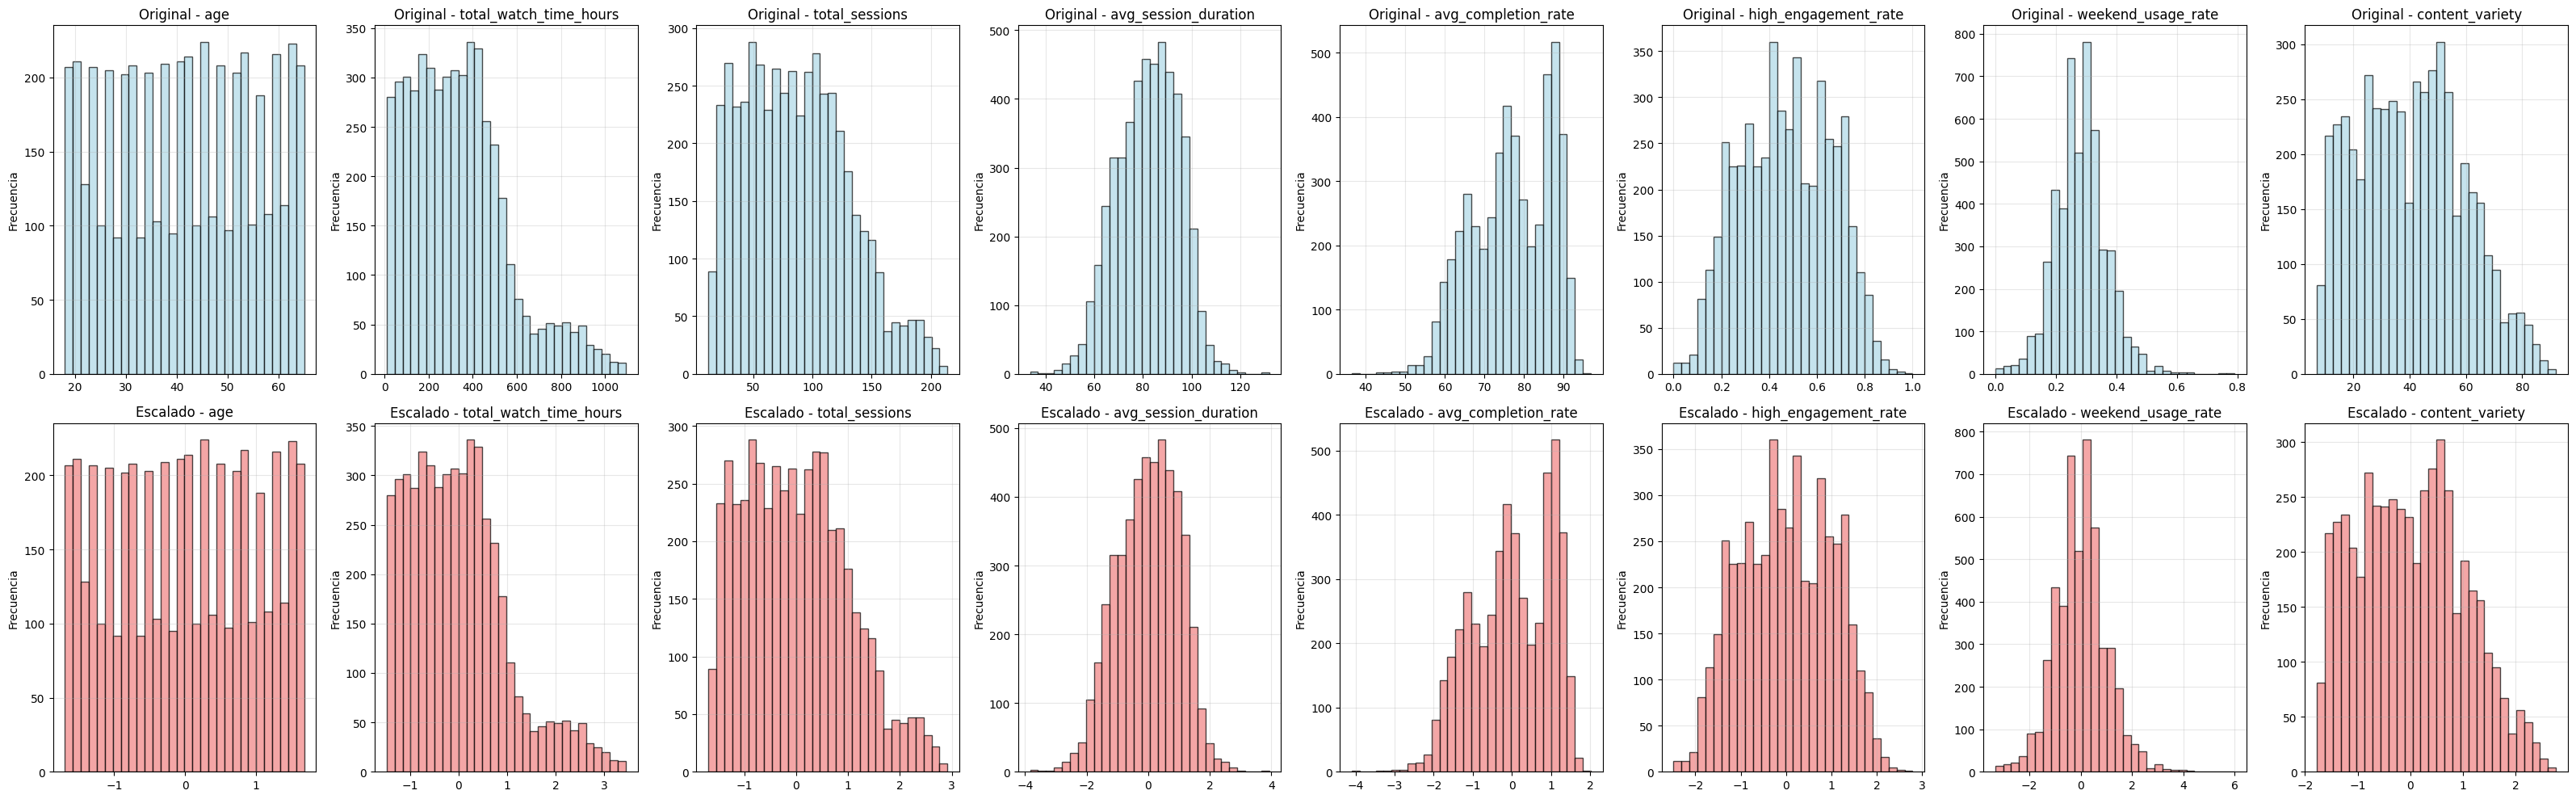

In [6]:
def scale_features(data, features):
    print("ESCALAMIENTO DE CARACTER√çSTICAS")
    print("="*50)
    
    # Inicializar el escalador
    scaler = StandardScaler()
    
    # Escalar los datos
    scaled_data = scaler.fit_transform(data[features])
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)
    
    print("Datos escalados usando StandardScaler")
    
    # Mostrar estad√≠sticas antes y despu√©s del escalamiento
    print(f"\nComparaci√≥n antes/despu√©s del escalamiento:")
    
    comparison_stats = pd.DataFrame({
        'Feature': features,
        'Original_Mean': data[features].mean().values,
        'Original_Std': data[features].std().values,
        'Scaled_Mean': scaled_df.mean().values,
        'Scaled_Std': scaled_df.std().values
    })
    
    display(comparison_stats.round(3))
    
    # Visualizar distribuciones antes y despu√©s
    fig, axes = plt.subplots(2, len(features), figsize=(4*len(features), 10))
    if len(features) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, feature in enumerate(features):
        # Distribuci√≥n original
        axes[0, i].hist(data[feature], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
        axes[0, i].set_title(f'Original - {feature}')
        axes[0, i].set_ylabel('Frecuencia')
        axes[0, i].grid(True, alpha=0.3)
        
        # Distribuci√≥n escalada
        axes[1, i].hist(scaled_df[feature], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1, i].set_title(f'Escalado - {feature}')
        axes[1, i].set_ylabel('Frecuencia')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return scaled_df, scaler

scaled_data, scaler = scale_features(clustering_data, features)

## Determining the Optimal Number of Clusters

DETERMINACI√ìN DEL N√öMERO √ìPTIMO DE CLUSTERS
Evaluando k desde 2 hasta 10...
   k=2: Inercia=28515.23, Silhouette=0.247
   k=3: Inercia=24055.40, Silhouette=0.220
   k=4: Inercia=21736.11, Silhouette=0.183
   k=5: Inercia=20211.70, Silhouette=0.176
   k=6: Inercia=18834.93, Silhouette=0.179
   k=7: Inercia=17632.91, Silhouette=0.173
   k=8: Inercia=16599.77, Silhouette=0.171
   k=9: Inercia=15735.40, Silhouette=0.167
   k=10: Inercia=15018.93, Silhouette=0.168


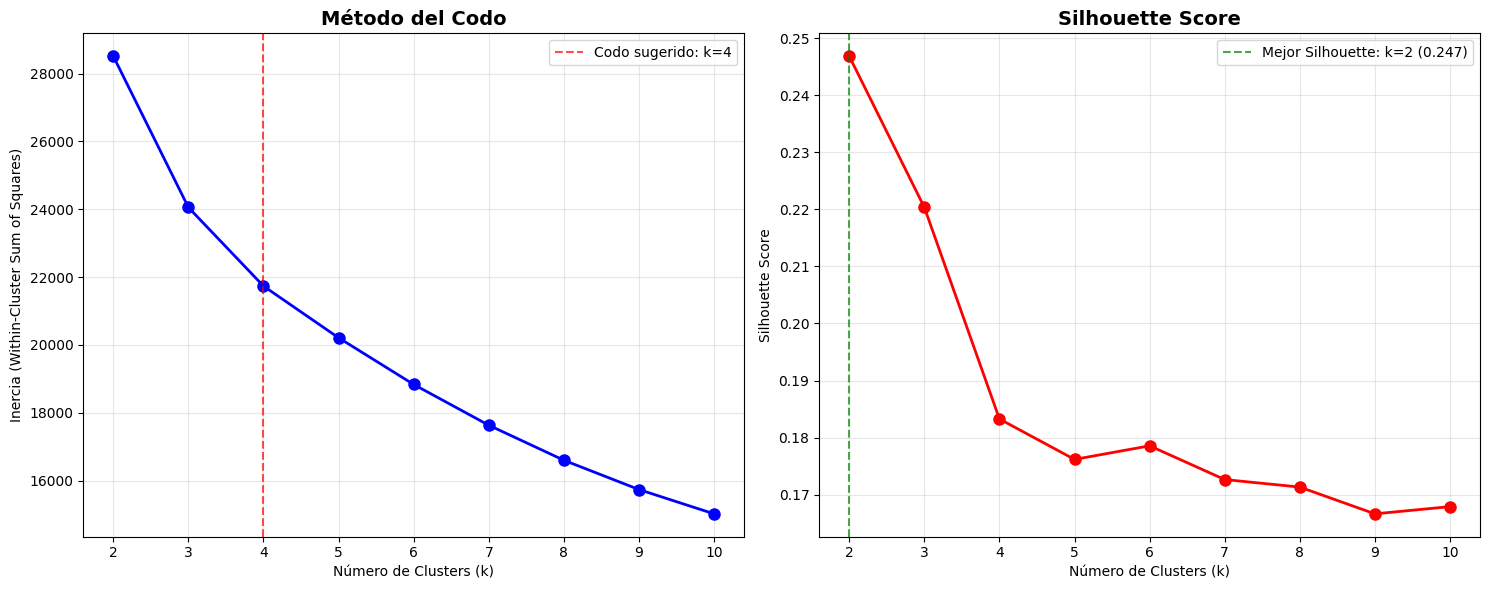


RECOMENDACIONES:
   ‚Ä¢ M√©todo del codo sugiere: k = 4
   ‚Ä¢ Mejor Silhouette Score: k = 2 (score = 0.247)
   ‚Ä¢ K √≥ptimo seleccionado: 2


In [7]:
def find_optimal_clusters(data, max_k=10):
    print("DETERMINACI√ìN DEL N√öMERO √ìPTIMO DE CLUSTERS")
    print("="*60)
    
    # Rango de n√∫mero de clusters a evaluar
    k_range = range(2, min(max_k + 1, len(data) // 10))  # M√≠nimo 10 observaciones por cluster
    
    # Listas para almacenar m√©tricas
    inertias = []
    silhouette_scores = []
    
    print(f"Evaluando k desde {min(k_range)} hasta {max(k_range)}...")
    
    for k in k_range:
        # Entrenar K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        
        # Calcular m√©tricas
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        inertias.append(inertia)
        silhouette_scores.append(silhouette_avg)
        
        print(f"   k={k}: Inercia={inertia:.2f}, Silhouette={silhouette_avg:.3f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # M√©todo del codo
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_title('M√©todo del Codo', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('N√∫mero de Clusters (k)')
    axes[0].set_ylabel('Inercia (Within-Cluster Sum of Squares)')
    axes[0].grid(True, alpha=0.3)
    
    # Calcular la diferencia segunda para encontrar el codo
    if len(inertias) >= 3:
        diffs = np.diff(inertias)
        diffs2 = np.diff(diffs)
        elbow_idx = np.argmax(diffs2) + 2  # +2 porque perdemos 2 elementos con las diferencias
        if elbow_idx < len(k_range):
            elbow_k = list(k_range)[elbow_idx]
            axes[0].axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, label=f'Codo sugerido: k={elbow_k}')
            axes[0].legend()
    
    # Silhouette Score
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_title('Silhouette Score', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('N√∫mero de Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True, alpha=0.3)
    
    # Marcar el mejor silhouette score
    best_silhouette_idx = np.argmax(silhouette_scores)
    best_k = list(k_range)[best_silhouette_idx]
    axes[1].axvline(x=best_k, color='green', linestyle='--', alpha=0.7, 
                   label=f'Mejor Silhouette: k={best_k} ({silhouette_scores[best_silhouette_idx]:.3f})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    print(f"\nRECOMENDACIONES:")
    print(f"   ‚Ä¢ M√©todo del codo sugiere: k = {elbow_k if 'elbow_k' in locals() else 'No determinado'}")
    print(f"   ‚Ä¢ Mejor Silhouette Score: k = {best_k} (score = {silhouette_scores[best_silhouette_idx]:.3f})")
    
    # Seleccionar k √≥ptimo (priorizamos silhouette score)
    optimal_k = best_k
    print(f"   ‚Ä¢ K √≥ptimo seleccionado: {optimal_k}")
    
    return optimal_k, k_range, inertias, silhouette_scores

# Encontrar n√∫mero √≥ptimo de clusters
optimal_k, k_range, inertias, silhouette_scores = find_optimal_clusters(scaled_data)
    

## Application of K-Means Clustering

In [8]:
def apply_kmeans_clustering(data, features, k, original_data):
    print(f"APLICANDO K-MEANS CLUSTERING (k={k})")
    print("="*60)
    
    # Entrenar modelo K-means final
    kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(data)
    
    # Agregar etiquetas de cluster a los datos originales
    clustered_data = original_data.copy()
    clustered_data['cluster'] = cluster_labels
    
    # Calcular m√©tricas finales
    silhouette_avg = silhouette_score(data, cluster_labels)
    inertia = kmeans_final.inertia_
    
    print(f"Clustering completado:")
    print(f"   ‚Ä¢ Silhouette Score: {silhouette_avg:.3f}")
    print(f"   ‚Ä¢ Inercia: {inertia:.2f}")
    print(f"   ‚Ä¢ Clusters creados: {k}")
    
    # Distribuci√≥n de clusters
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print(f"\nDistribuci√≥n de usuarios por cluster:")
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(cluster_labels)) * 100
        print(f"   ‚Ä¢ Cluster {cluster_id}: {count:,} usuarios ({percentage:.1f}%)")
    
    return kmeans_final, clustered_data, cluster_labels

kmeans_model, clustered_data, labels = apply_kmeans_clustering(scaled_data, features, optimal_k, clustering_data)

APLICANDO K-MEANS CLUSTERING (k=2)
Clustering completado:
   ‚Ä¢ Silhouette Score: 0.247
   ‚Ä¢ Inercia: 28515.23
   ‚Ä¢ Clusters creados: 2

Distribuci√≥n de usuarios por cluster:
   ‚Ä¢ Cluster 0: 2,499 usuarios (50.0%)
   ‚Ä¢ Cluster 1: 2,501 usuarios (50.0%)


## Cluster Analysis and Characterization

AN√ÅLISIS Y CARACTERIZACI√ìN DE CLUSTERS
ESTAD√çSTICAS POR CLUSTER:


age               total_watch_time_hours                 \
          mean    std median                   mean     std median   
cluster                                                              
0        38.95  13.07   37.0                 415.90  249.15  399.9   
1        44.23  14.26   47.0                 254.25  147.34  248.1   

        total_sessions               avg_session_duration  ...  \
                  mean    std median                 mean  ...   
cluster                                                    ...   
0               104.83  45.77  107.0                91.45  ...   
1                67.46  32.46   65.0                72.91  ...   

        avg_completion_rate high_engagement_rate               \
                     median                 mean   std median   
cluster                                                         
0                     86.11                 0.62  0.12   0.63   
1                     69.12                 0.32  0.12   0.32   

        weekend_usage_rate              content_variety                
                      mean   std median            mean    std median  
cluster                                                                
0                     0.29  0.08   0.28           47.98  19.14   50.0  
1                     0.28  0.09   0.28           32.50  14.71   32.0  

[2 rows x 24 columns]


PERFILES DETALLADOS DE CLUSTERS:

üî∏ Cluster_1:
   ‚Ä¢ Usuarios: 2,501 (50.0%)
   ‚Ä¢ age: Œº=44.23, mediana=47.00
   ‚Ä¢ total_watch_time_hours: Œº=254.25, mediana=248.10
   ‚Ä¢ total_sessions: Œº=67.46, mediana=65.00
   ‚Ä¢ avg_session_duration: Œº=72.91, mediana=73.20
   ‚Ä¢ avg_completion_rate: Œº=69.10, mediana=69.12
   ‚Ä¢ high_engagement_rate: Œº=0.32, mediana=0.32
   ‚Ä¢ weekend_usage_rate: Œº=0.28, mediana=0.28
   ‚Ä¢ content_variety: Œº=32.50, mediana=32.00

üî∏ Cluster_0:
   ‚Ä¢ Usuarios: 2,499 (50.0%)
   ‚Ä¢ age: Œº=38.95, mediana=37.00
   ‚Ä¢ total_watch_time_hours: Œº=415.90, mediana=399.90
   ‚Ä¢ total_sessions: Œº=104.83, mediana=107.00
   ‚Ä¢ avg_session_duration: Œº=91.45, mediana=91.40
   ‚Ä¢ avg_completion_rate: Œº=84.72, mediana=86.11
   ‚Ä¢ high_engagement_rate: Œº=0.62, mediana=0.63
   ‚Ä¢ weekend_usage_rate: Œº=0.29, mediana=0.28
   ‚Ä¢ content_variety: Œº=47.98, mediana=50.00


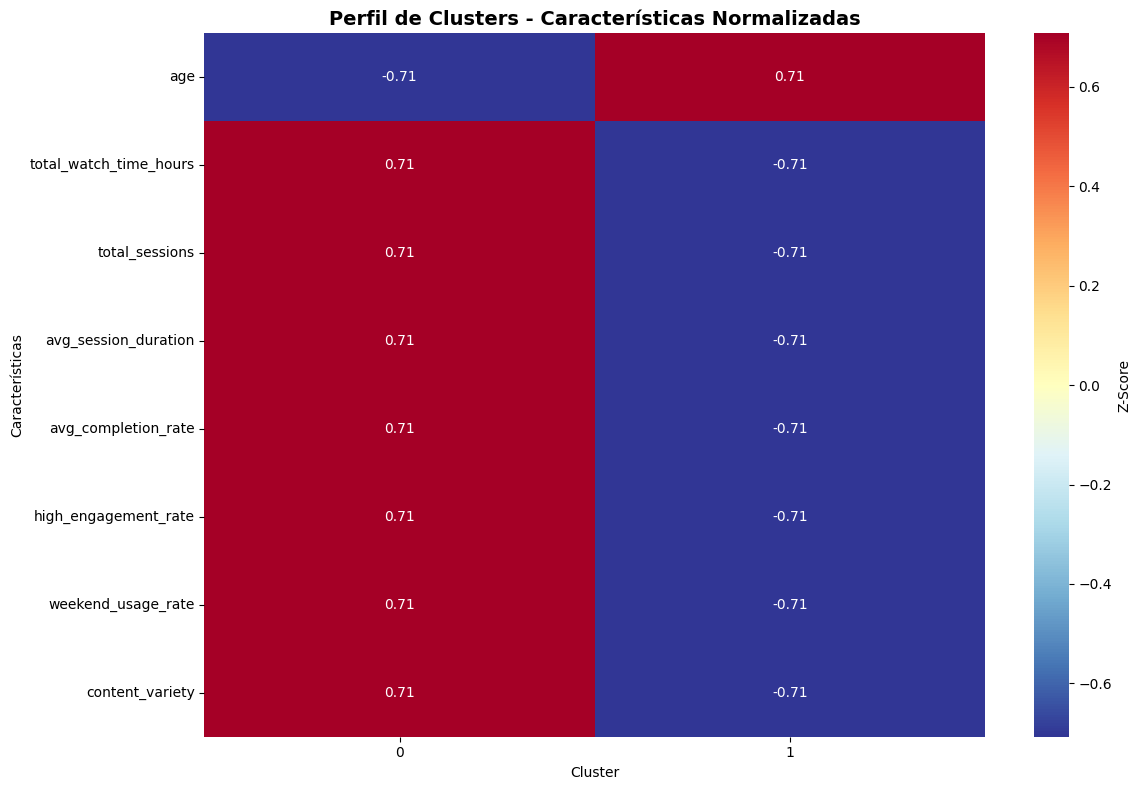

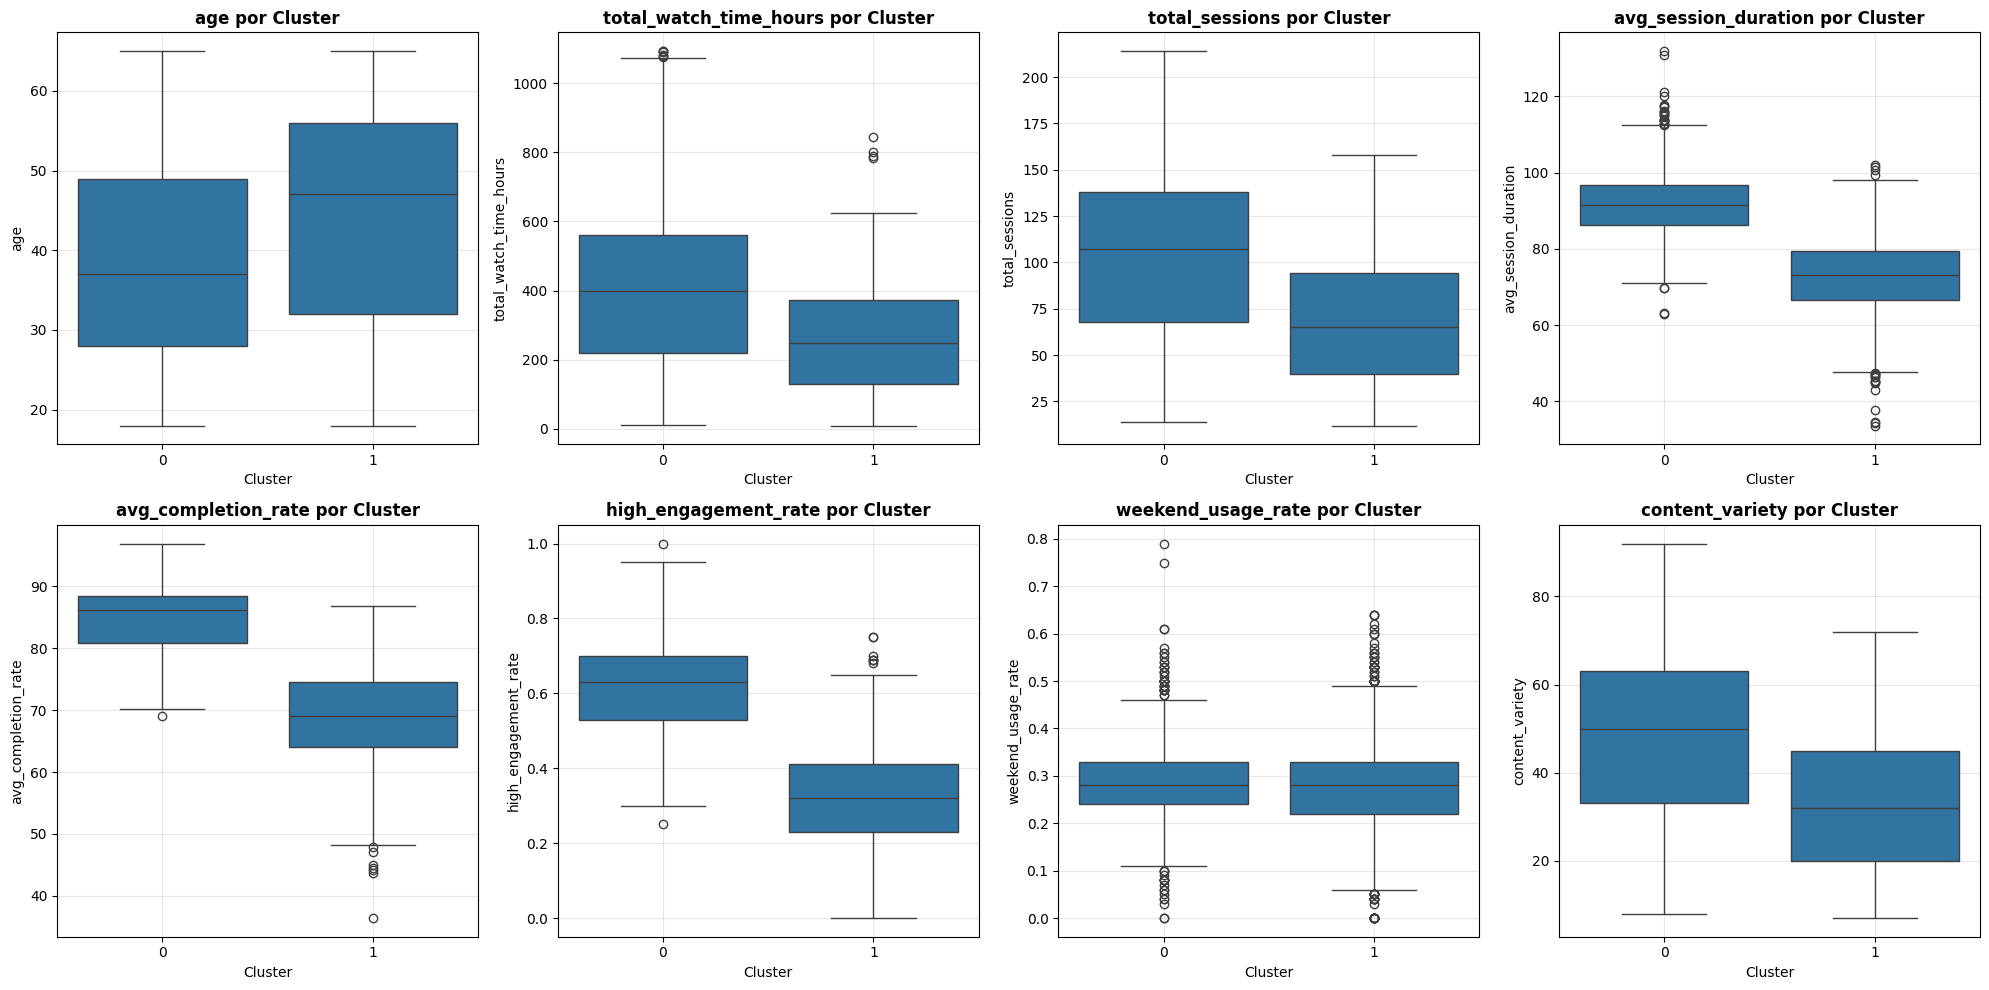

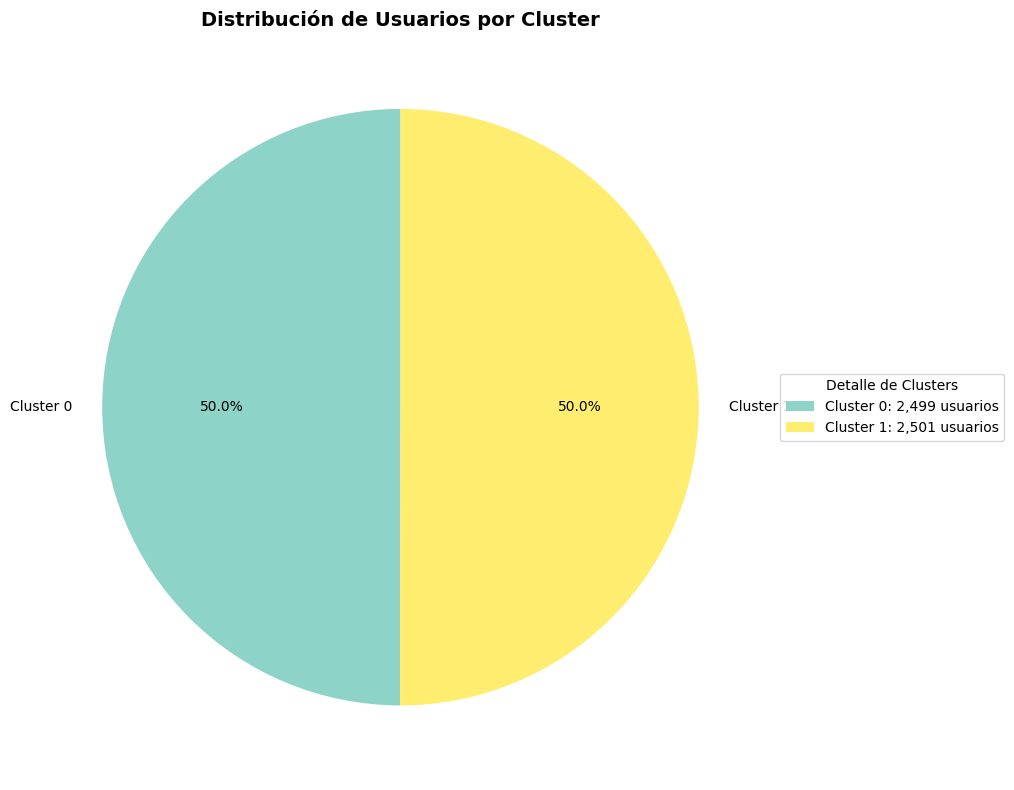

In [9]:
def analyze_clusters(clustered_data, features, labels):
    print("AN√ÅLISIS Y CARACTERIZACI√ìN DE CLUSTERS")
    print("="*60)
    
    # Estad√≠sticas por cluster
    cluster_stats = clustered_data.groupby('cluster')[features].agg(['mean', 'std', 'median'])
    
    print("ESTAD√çSTICAS POR CLUSTER:")
    display(cluster_stats.round(2))
    
    # Crear perfiles de clusters
    cluster_profiles = {}
    
    for cluster_id in clustered_data['cluster'].unique():
        cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
        n_users = len(cluster_data)
        
        # Calcular caracter√≠sticas distintivas
        profile = {
            'n_users': n_users,
            'percentage': (n_users / len(clustered_data)) * 100
        }
        
        # Agregar estad√≠sticas de cada feature
        for feature in features:
            profile[f'{feature}_mean'] = cluster_data[feature].mean()
            profile[f'{feature}_median'] = cluster_data[feature].median()
        
        cluster_profiles[f'Cluster_{cluster_id}'] = profile
    
    print(f"\nPERFILES DETALLADOS DE CLUSTERS:")
    for cluster_name, profile in cluster_profiles.items():
        print(f"\nüî∏ {cluster_name}:")
        print(f"   ‚Ä¢ Usuarios: {profile['n_users']:,} ({profile['percentage']:.1f}%)")
        
        for feature in features:
            mean_val = profile[f'{feature}_mean']
            median_val = profile[f'{feature}_median']
            print(f"   ‚Ä¢ {feature}: Œº={mean_val:.2f}, mediana={median_val:.2f}")
    
    n_features = len(features)
    n_clusters = len(clustered_data['cluster'].unique())
    
    # 1. Heatmap de caracter√≠sticas por cluster
    plt.figure(figsize=(12, 8))
    
    # Preparar datos para heatmap (medias normalizadas)
    cluster_means = clustered_data.groupby('cluster')[features].mean()
    
    # Normalizar para mejor visualizaci√≥n
    cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()
    
    sns.heatmap(cluster_means_normalized.T, annot=True, cmap='RdYlBu_r', center=0,
                fmt='.2f', cbar_kws={'label': 'Z-Score'})
    plt.title('Perfil de Clusters - Caracter√≠sticas Normalizadas', fontweight='bold', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Caracter√≠sticas')
    plt.tight_layout()
    plt.show()
    
    # 2. Box plots por cluster para cada caracter√≠stica
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(5 * ((n_features + 1) // 2), 10))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for i, feature in enumerate(features):
        if i < len(axes):
            sns.boxplot(data=clustered_data, x='cluster', y=feature, ax=axes[i])
            axes[i].set_title(f'{feature} por Cluster', fontweight='bold')
            axes[i].set_xlabel('Cluster')
            axes[i].grid(True, alpha=0.3)
    
    # Ocultar ejes extra
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Distribuci√≥n de clusters (pie chart)
    plt.figure(figsize=(10, 8))
    
    cluster_counts = clustered_data['cluster'].value_counts().sort_index()
    colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_counts)))
    
    wedges, texts, autotexts = plt.pie(cluster_counts.values, 
                                      labels=[f'Cluster {i}' for i in cluster_counts.index],
                                      autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Distribuci√≥n de Usuarios por Cluster', fontweight='bold', fontsize=14)
    
    # Agregar leyenda con informaci√≥n adicional
    legend_labels = []
    for cluster_id, count in cluster_counts.items():
        legend_labels.append(f'Cluster {cluster_id}: {count:,} usuarios')
    
    plt.legend(wedges, legend_labels, title="Detalle de Clusters", 
              loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.tight_layout()
    plt.show()
    
    return cluster_profiles, cluster_stats

profiles, stats = analyze_clusters(clustered_data, features, labels)


## Interpretation of Clusters (User Segmentation)

In [10]:
def interpret_clusters(cluster_profiles, features):
    print("INTERPRETACI√ìN Y SEGMENTACI√ìN DE USUARIOS")
    print("="*60)
    
    # Funci√≥n para interpretar un cluster basado en percentiles
    def interpret_single_cluster(cluster_name, profile, all_profiles):
        interpretation = {
            'name': cluster_name,
            'size': profile['n_users'],
            'percentage': profile['percentage'],
            'characteristics': [],
            'business_label': '',
            'recommendations': []
        }
        
        for feature in features:
            cluster_mean = profile[f'{feature}_mean']
            
            # Calcular promedio general
            all_means = [p[f'{feature}_mean'] for p in all_profiles.values()]
            overall_mean = np.mean(all_means)
            overall_std = np.std(all_means)
            
            # Determinar si est√° por encima o debajo del promedio
            z_score = (cluster_mean - overall_mean) / overall_std if overall_std > 0 else 0
            
            if z_score > 0.5:
                level = "Alto"
            elif z_score < -0.5:
                level = "Bajo"
            else:
                level = "Promedio"
            
            interpretation['characteristics'].append({
                'feature': feature,
                'value': cluster_mean,
                'level': level,
                'z_score': z_score
            })
        
        return interpretation
    
    # Interpretar cada cluster
    interpretations = {}
    for cluster_name, profile in cluster_profiles.items():
        interpretations[cluster_name] = interpret_single_cluster(cluster_name, profile, cluster_profiles)
    
    # Asignar etiquetas de negocio basadas en caracter√≠sticas
    business_labels = {}
    recommendations = {}
    
    for cluster_name, interp in interpretations.items():
        cluster_id = cluster_name.split('_')[1]
        
        # L√≥gica para asignar etiquetas (personalizar seg√∫n caracter√≠sticas espec√≠ficas)
        high_features = [c['feature'] for c in interp['characteristics'] if c['level'] == 'Alto']
        low_features = [c['feature'] for c in interp['characteristics'] if c['level'] == 'Bajo']
        
        # Determinar etiqueta de negocio
        if 'total_watch_time_hours' in high_features and 'avg_completion_rate' in high_features:
            label = "Heavy Engaged Users"
            recs = ["Programa de lealtad premium", "Early access a contenido nuevo", "Recomendaciones personalizadas avanzadas"]
        elif 'age' in high_features:
            label = "Mature Audience"
            recs = ["Contenido cl√°sico y documentales", "Interface simplificada", "Soporte t√©cnico dedicado"]
        elif 'total_watch_time_hours' in high_features:
            label = "Heavy Watchers"
            recs = ["Planes de suscripci√≥n premium", "Contenido en calidad 4K", "Descarga offline ilimitada"]
        elif 'avg_completion_rate' in high_features:
            label = "Quality Seekers"
            recs = ["Contenido curado de alta calidad", "Recomendaciones basadas en ratings", "Acceso anticipado a series exclusivas"]
        elif 'total_sessions' in high_features:
            label = "Frequent Users"
            recs = ["Notificaciones personalizadas", "Funciones de continuidad mejoradas", "Multi-dispositivo premium"]
        else:
            label = "üë• Casual Users"
            recs = ["Contenido popular y trending", "Ofertas promocionales", "Interfaz simplificada"]
        
        business_labels[cluster_name] = label
        recommendations[cluster_name] = recs
        
        # Mostrar interpretaci√≥n detallada
        print(f"\nüî∏ {cluster_name} - {label}")
        print(f"   Tama√±o: {interp['size']:,} usuarios ({interp['percentage']:.1f}%)")
        print(f"   Caracter√≠sticas principales:")
        
        for char in interp['characteristics']:
            emoji = "üî∫" if char['level'] == "Alto" else "üîª" if char['level'] == "Bajo" else "‚ûñ"
            print(f"      {emoji} {char['feature']}: {char['value']:.2f} ({char['level']})")
        
        print(f"   Recomendaciones de negocio:")
        for i, rec in enumerate(recs, 1):
            print(f"      {i}. {rec}")
    
    return interpretations, business_labels, recommendations

interpretations, labels, recommendations = interpret_clusters(profiles, features)


INTERPRETACI√ìN Y SEGMENTACI√ìN DE USUARIOS

üî∏ Cluster_1 - Mature Audience
   Tama√±o: 2,501 usuarios (50.0%)
   Caracter√≠sticas principales:
      üî∫ age: 44.23 (Alto)
      üîª total_watch_time_hours: 254.25 (Bajo)
      üîª total_sessions: 67.46 (Bajo)
      üîª avg_session_duration: 72.91 (Bajo)
      üîª avg_completion_rate: 69.10 (Bajo)
      üîª high_engagement_rate: 0.32 (Bajo)
      üîª weekend_usage_rate: 0.28 (Bajo)
      üîª content_variety: 32.50 (Bajo)
   Recomendaciones de negocio:
      1. Contenido cl√°sico y documentales
      2. Interface simplificada
      3. Soporte t√©cnico dedicado

üî∏ Cluster_0 - Heavy Engaged Users
   Tama√±o: 2,499 usuarios (50.0%)
   Caracter√≠sticas principales:
      üîª age: 38.95 (Bajo)
      üî∫ total_watch_time_hours: 415.90 (Alto)
      üî∫ total_sessions: 104.83 (Alto)
      üî∫ avg_session_duration: 91.45 (Alto)
      üî∫ avg_completion_rate: 84.72 (Alto)
      üî∫ high_engagement_rate: 0.62 (Alto)
      üî∫ wee

## Cluster Visualization

VISUALIZACIONES AVANZADAS DE CLUSTERS
Aplicando PCA para visualizaci√≥n 2D...
   ‚Ä¢ PC1 explica: 41.7% de la varianza
   ‚Ä¢ PC2 explica: 20.4% de la varianza
   ‚Ä¢ Total explicado: 62.1%


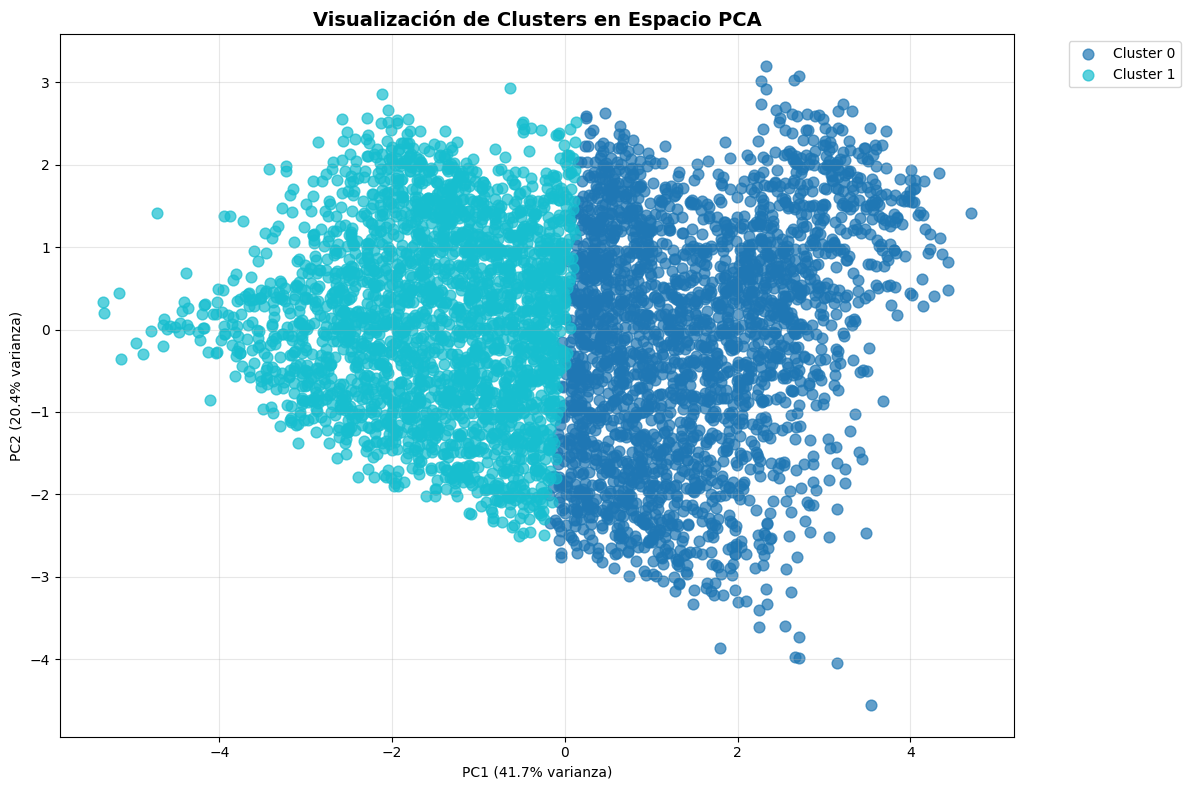


Creando Silhouette Plot...


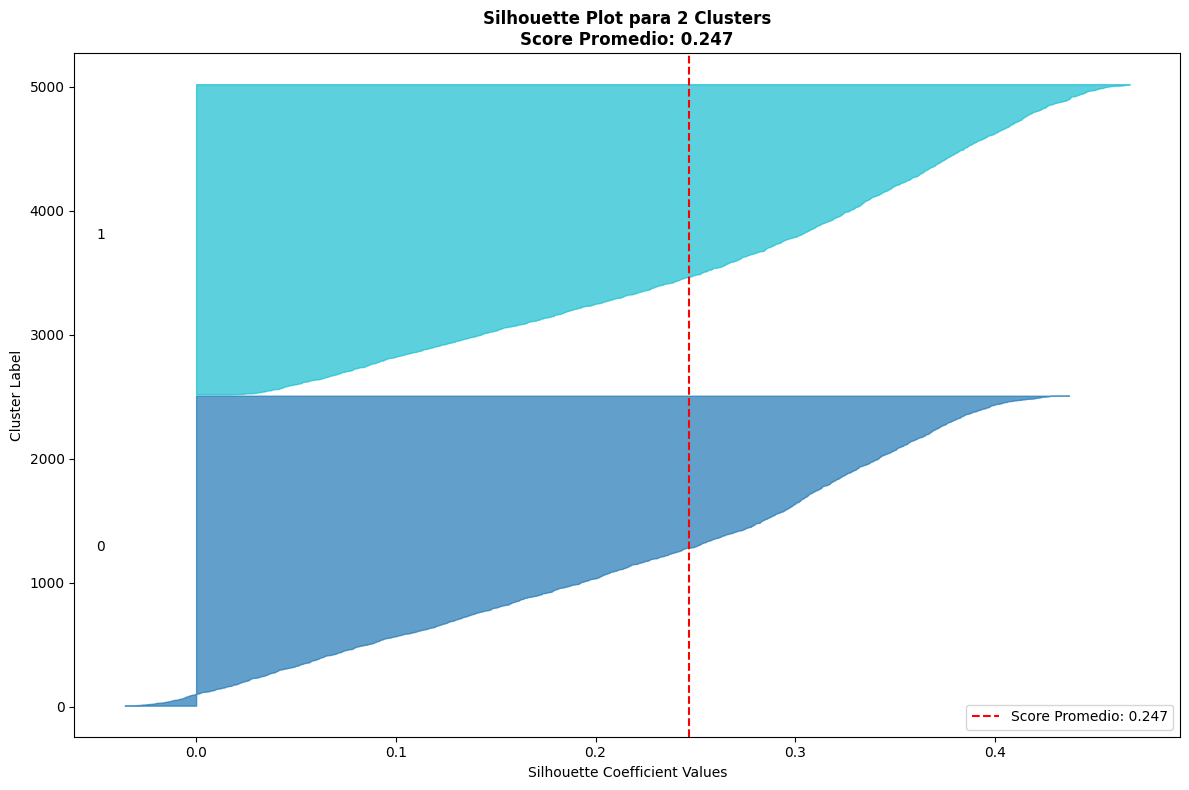


üï∏Ô∏è Creando Radar Chart...


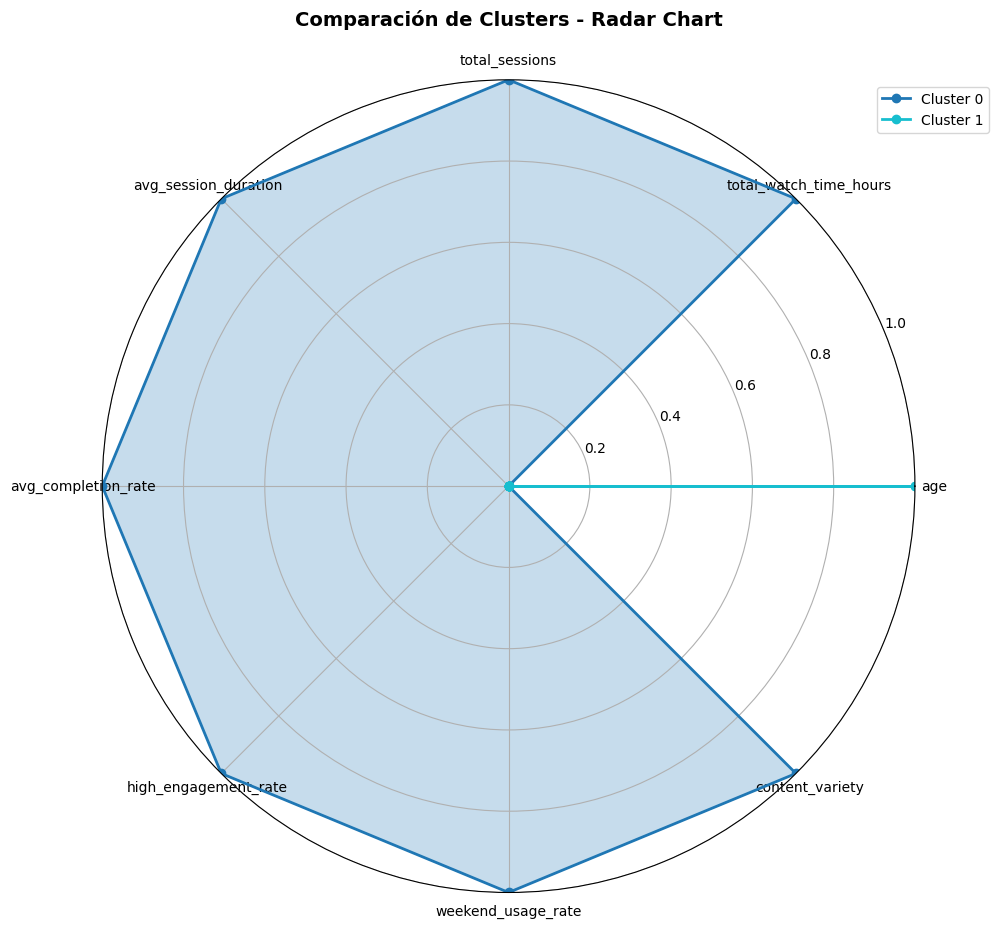

In [11]:
def create_cluster_visualizations(clustered_data, features, scaled_data, labels):
    print("VISUALIZACIONES AVANZADAS DE CLUSTERS")
    print("="*50)
    
    # 1. PCA para visualizaci√≥n en 2D
    print("Aplicando PCA para visualizaci√≥n 2D...")
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    pca_df = pd.DataFrame({
        'PC1': pd.Series(pca_result[:, 0], index=scaled_data.index),
        'PC2': pd.Series(pca_result[:, 1], index=scaled_data.index),
        'cluster': pd.Series(labels, index=scaled_data.index)
    })
    
    # Explicar varianza
    explained_variance = pca.explained_variance_ratio_
    print(f"   ‚Ä¢ PC1 explica: {explained_variance[0]:.1%} de la varianza")
    print(f"   ‚Ä¢ PC2 explica: {explained_variance[1]:.1%} de la varianza")
    print(f"   ‚Ä¢ Total explicado: {sum(explained_variance):.1%}")
    
    # Scatter plot con PCA
    plt.figure(figsize=(12, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels))))
    
    for i, cluster_id in enumerate(np.unique(labels)):
        cluster_points = pca_df[pca_df['cluster'] == cluster_id]
        plt.scatter(cluster_points['PC1'], cluster_points['PC2'], 
                   c=[colors[i]], label=f'Cluster {cluster_id}', 
                   alpha=0.7, s=60)
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} varianza)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} varianza)')
    plt.title('Visualizaci√≥n de Clusters en Espacio PCA', fontweight='bold', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Silhouette Plot
    print("\nCreando Silhouette Plot...")
    
    silhouette_avg = silhouette_score(scaled_data, labels)
    sample_silhouette_values = silhouette_samples(scaled_data, labels)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_lower = 10
    for i in range(len(np.unique(labels))):
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()
        
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colors[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,\
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')
    ax.set_title(f'Silhouette Plot para {len(np.unique(labels))} Clusters\n'\
                f'Score Promedio: {silhouette_avg:.3f}', fontweight='bold')
    
    # L√≠nea vertical para el score promedio
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", 
               label=f'Score Promedio: {silhouette_avg:.3f}')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. Radar Chart para comparaci√≥n de clusters
    if len(features) >= 3:
        print("\nüï∏Ô∏è Creando Radar Chart...")
        
        # Preparar datos para radar chart
        cluster_means = clustered_data.groupby('cluster')[features].mean()
        
        # Normalizar entre 0 y 1 para el radar chart
        normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
        
        # Configurar radar chart
        angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Cerrar el c√≠rculo
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        
        for i, cluster_id in enumerate(normalized_means.index):
            values = normalized_means.loc[cluster_id].values
            values = np.concatenate((values, [values[0]]))  # Cerrar el c√≠rculo
            
            ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[i])
            ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features)
        ax.set_ylim(0, 1)
        ax.set_title('Comparaci√≥n de Clusters - Radar Chart', fontweight='bold', fontsize=14, pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0))
        plt.tight_layout()
        plt.show()
    
    return pca_df, explained_variance

pca_df, variance_explained = create_cluster_visualizations(clustered_data, features, scaled_data, clustered_data['cluster'].values)

## Preparaci√≥n de Datos para Modelado Predictivo

In [12]:
def prepare_retention_model_data(user_metrics, df_main=None):
    """
    Preparar datos para modelo de predicci√≥n de retenci√≥n
    """
    print(" PREPARACI√ìN DE DATOS PARA MODELO DE RETENCI√ìN")
    print("="*60)
    
    # Crear variable objetivo 'retained' basada en total_watch_time_hours
    if 'total_watch_time_hours' in user_metrics.columns:
        # Definir retenci√≥n basada en la mediana de tiempo de visualizaci√≥n
        median_watch_time = user_metrics['total_watch_time_hours'].median()
        user_metrics['retained'] = (user_metrics['total_watch_time_hours'] > median_watch_time).astype(int)
        
        print(f"Variable objetivo 'retained' creada:")
        print(f"   ‚Ä¢ Criterio: total_watch_time_hours > {median_watch_time:.2f} horas")
        print(f"   ‚Ä¢ Usuarios retenidos: {user_metrics['retained'].sum():,} ({user_metrics['retained'].mean()*100:.1f}%)")
        print(f"   ‚Ä¢ Usuarios no retenidos: {(1-user_metrics['retained']).sum():,} ({(1-user_metrics['retained']).mean()*100:.1f}%)")
    else:
        print(" Error: columna 'total_watch_time_hours' no encontrada")
        return None, None
    
    # Seleccionar caracter√≠sticas para el modelo
    feature_columns = []
    
    # Caracter√≠sticas demogr√°ficas
    if 'age' in user_metrics.columns:
        feature_columns.append('age')
    
    # Caracter√≠sticas de comportamiento
    behavioral_features = ['total_sessions', 'avg_session_duration', 'avg_completion_rate', 
                          'high_engagement_rate', 'weekend_usage_rate', 'content_variety']
    
    for feature in behavioral_features:
        if feature in user_metrics.columns:
            feature_columns.append(feature)
    
    # Caracter√≠sticas categ√≥ricas
    if 'subscription_type' in user_metrics.columns:
        # Codificar subscription_type
        le = LabelEncoder()
        user_metrics['subscription_type_encoded'] = le.fit_transform(user_metrics['subscription_type'].astype(str))
        feature_columns.append('subscription_type_encoded')
        print(f"   ‚Ä¢ subscription_type codificado: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    # Si no tenemos suficientes caracter√≠sticas, crear algunas adicionales
    if len(feature_columns) < 3:
        print(" Creando caracter√≠sticas adicionales b√°sicas...")
        
        if 'total_watch_time_hours' in user_metrics.columns:
            # Crear cuartiles de tiempo de visualizaci√≥n como feature
            user_metrics['watch_time_quartile'] = pd.qcut(user_metrics['total_watch_time_hours'], 
                                                         q=4, labels=[0, 1, 2, 3]).astype(float)
            feature_columns.append('watch_time_quartile')
        
        if 'age' in user_metrics.columns:
            # Crear grupos de edad
            user_metrics['age_group_encoded'] = pd.cut(user_metrics['age'], 
                                                      bins=[0, 30, 45, 100], labels=[0, 1, 2]).astype(float)
            feature_columns.append('age_group_encoded')
    
    print(f"\nCaracter√≠sticas seleccionadas para el modelo:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i}. {feature}")
    
    # Crear dataset limpio para modelado
    model_data = user_metrics[feature_columns + ['retained']].dropna()
    
    print(f"\n Dataset para modelado:")
    print(f"   ‚Ä¢ Registros totales: {len(model_data):,}")
    print(f"   ‚Ä¢ Caracter√≠sticas: {len(feature_columns)}")
    print(f"   ‚Ä¢ Registros con valores nulos eliminados: {len(user_metrics) - len(model_data):,}")
    
    # Separar caracter√≠sticas y variable objetivo
    X = model_data[feature_columns]
    y = model_data['retained']
    
    # Mostrar correlaciones con la variable objetivo
    print(f"\n Correlaciones con variable objetivo (retained):")
    correlations = X.corrwith(y).sort_values(key=abs, ascending=False)
    for feature, corr in correlations.items():
        print(f"   ‚Ä¢ {feature}: {corr:.3f}")
    
    return X, y, feature_columns

# Preparar datos para modelo de retenci√≥n
X, y, model_features = prepare_retention_model_data(user_metrics, df_main)

if X is not None:
    print("Datos preparados exitosamente para modelado predictivo")
else:
    print(" Error en preparaci√≥n de datos")


 PREPARACI√ìN DE DATOS PARA MODELO DE RETENCI√ìN
Variable objetivo 'retained' creada:
   ‚Ä¢ Criterio: total_watch_time_hours > 312.35 horas
   ‚Ä¢ Usuarios retenidos: 2,500 (50.0%)
   ‚Ä¢ Usuarios no retenidos: 2,500 (50.0%)
   ‚Ä¢ subscription_type codificado: {'Basic': np.int64(0), 'Premium': np.int64(1), 'Standard': np.int64(2)}

Caracter√≠sticas seleccionadas para el modelo:
   1. age
   2. total_sessions
   3. avg_session_duration
   4. avg_completion_rate
   5. high_engagement_rate
   6. weekend_usage_rate
   7. content_variety
   8. subscription_type_encoded

 Dataset para modelado:
   ‚Ä¢ Registros totales: 5,000
   ‚Ä¢ Caracter√≠sticas: 8
   ‚Ä¢ Registros con valores nulos eliminados: 0

 Correlaciones con variable objetivo (retained):
   ‚Ä¢ avg_completion_rate: 0.200
   ‚Ä¢ high_engagement_rate: 0.195
   ‚Ä¢ avg_session_duration: 0.178
   ‚Ä¢ subscription_type_encoded: 0.093
   ‚Ä¢ age: -0.086
   ‚Ä¢ total_sessions: 0.082
   ‚Ä¢ content_variety: 0.074
   ‚Ä¢ weekend_usage_r

## Divisi√≥n de Datos y Entrenamiento del Modelo

In [13]:
def train_retention_model(X, y, feature_names, test_size=0.2):
    """
    Entrenar modelo de regresi√≥n log√≠stica para predicci√≥n de retenci√≥n
    """
    print("ENTRENAMIENTO DEL MODELO DE RETENCI√ìN")
    print("="*60)
    
    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Divisi√≥n de datos:")
    print(f"   ‚Ä¢ Entrenamiento: {len(X_train):,} muestras ({(1-test_size)*100:.0f}%)")
    print(f"   ‚Ä¢ Prueba: {len(X_test):,} muestras ({test_size*100:.0f}%)")
    print(f"   ‚Ä¢ Distribuci√≥n en entrenamiento: {y_train.value_counts().to_dict()}")
    print(f"   ‚Ä¢ Distribuci√≥n en prueba: {y_test.value_counts().to_dict()}")
    
    # Escalar caracter√≠sticas
    scaler_model = StandardScaler()
    X_train_scaled = scaler_model.fit_transform(X_train)
    X_test_scaled = scaler_model.transform(X_test)
    
    print(f"\n Caracter√≠sticas escaladas usando StandardScaler")
    
    # Entrenar modelo de Regresi√≥n Log√≠stica
    print(f"\nEntrenando Regresi√≥n Log√≠stica...")
    
    logistic_model = LogisticRegression(random_state=42, max_iter=1000)
    logistic_model.fit(X_train_scaled, y_train)
    
    # Realizar predicciones
    y_pred_train = logistic_model.predict(X_train_scaled)
    y_pred_test = logistic_model.predict(X_test_scaled)
    
    y_pred_proba_train = logistic_model.predict_proba(X_train_scaled)[:, 1]
    y_pred_proba_test = logistic_model.predict_proba(X_test_scaled)[:, 1]
    
    print("Modelo entrenado exitosamente")
    
    return (logistic_model, scaler_model, 
            X_train, X_test, y_train, y_test,
            X_train_scaled, X_test_scaled,
            y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test)

# Entrenar modelo si los datos est√°n disponibles
if X is not None and y is not None:
    model_results = train_retention_model(X, y, model_features)
    (logistic_model, scaler_model, 
     X_train, X_test, y_train, y_test,
     X_train_scaled, X_test_scaled,
     y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test) = model_results
else:
    print(" No se puede entrenar el modelo sin datos preparados")

ENTRENAMIENTO DEL MODELO DE RETENCI√ìN
Divisi√≥n de datos:
   ‚Ä¢ Entrenamiento: 4,000 muestras (80%)
   ‚Ä¢ Prueba: 1,000 muestras (20%)
   ‚Ä¢ Distribuci√≥n en entrenamiento: {1: 2000, 0: 2000}
   ‚Ä¢ Distribuci√≥n en prueba: {0: 500, 1: 500}

 Caracter√≠sticas escaladas usando StandardScaler

Entrenando Regresi√≥n Log√≠stica...
Modelo entrenado exitosamente


## Evaluaci√≥n del Modelo

In [14]:
def evaluate_model(y_true, y_pred, y_pred_proba, dataset_name=""):
    """
    Evaluar modelo usando m√∫ltiples m√©tricas
    """
    print(f"EVALUACI√ìN DEL MODELO - {dataset_name}")
    print("="*50)
    
    # Calcular m√©tricas b√°sicas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"M√©tricas de Rendimiento:")
    print(f"   ‚Ä¢ Accuracy (Exactitud): {accuracy:.3f}")
    print(f"   ‚Ä¢ Precision (Precisi√≥n): {precision:.3f}")
    print(f"   ‚Ä¢ Recall (Sensibilidad): {recall:.3f}")
    print(f"   ‚Ä¢ F1-Score: {f1:.3f}")
    
    # Matriz de confusi√≥n
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\nMatriz de Confusi√≥n:")
    print(f"   Predicho:    0    1")
    print(f"   Real 0:    {cm[0,0]:4d} {cm[0,1]:4d}")
    print(f"   Real 1:    {cm[1,0]:4d} {cm[1,1]:4d}")
    
    # Calcular m√©tricas adicionales
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nM√©tricas Adicionales:")
    print(f"   ‚Ä¢ Verdaderos Positivos: {tp}")
    print(f"   ‚Ä¢ Verdaderos Negativos: {tn}")
    print(f"   ‚Ä¢ Falsos Positivos: {fp}")
    print(f"   ‚Ä¢ Falsos Negativos: {fn}")
    print(f"   ‚Ä¢ Especificidad: {specificity:.3f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'confusion_matrix': cm
    }

In [15]:
def plot_model_evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_test):
    """
    Crear visualizaciones para evaluaci√≥n del modelo
    """
    print("\nVISUALIZACIONES DE EVALUACI√ìN")
    print("="*40)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Matriz de Confusi√≥n para conjunto de prueba
    cm_test = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Matriz de Confusi√≥n - Conjunto de Prueba')
    axes[0, 0].set_xlabel('Predicho')
    axes[0, 0].set_ylabel('Real')
    
    # 2. Distribuci√≥n de probabilidades predichas
    axes[0, 1].hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.7, label='No Retenido', color='red')
    axes[0, 1].hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.7, label='Retenido', color='blue')
    axes[0, 1].set_xlabel('Probabilidad Predicha')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribuci√≥n de Probabilidades Predichas')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Comparaci√≥n de m√©tricas entre train y test
    train_metrics = evaluate_model(y_train, y_pred_train, None, "")
    test_metrics = evaluate_model(y_test, y_pred_test, None, "")
    
    metrics_comparison = pd.DataFrame({
        'Entrenamiento': [train_metrics['accuracy'], train_metrics['precision'], 
                         train_metrics['recall'], train_metrics['f1_score']],
        'Prueba': [test_metrics['accuracy'], test_metrics['precision'], 
                  test_metrics['recall'], test_metrics['f1_score']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    
    metrics_comparison.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Comparaci√≥n Train vs Test')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Feature Importance (coeficientes del modelo)
    if hasattr(logistic_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': model_features,
            'Coefficient': logistic_model.coef_[0],
            'Abs_Coefficient': np.abs(logistic_model.coef_[0])
        }).sort_values('Abs_Coefficient', ascending=True)
        
        colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
        axes[1, 1].barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
        axes[1, 1].set_xlabel('Coeficiente')
        axes[1, 1].set_title('Importancia de Caracter√≠sticas')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_comparison

EVALUACI√ìN COMPLETA DEL MODELO
EVALUACI√ìN DEL MODELO - ENTRENAMIENTO
M√©tricas de Rendimiento:
   ‚Ä¢ Accuracy (Exactitud): 0.600
   ‚Ä¢ Precision (Precisi√≥n): 0.600
   ‚Ä¢ Recall (Sensibilidad): 0.599
   ‚Ä¢ F1-Score: 0.599

Matriz de Confusi√≥n:
   Predicho:    0    1
   Real 0:    1201  799
   Real 1:     803 1197

M√©tricas Adicionales:
   ‚Ä¢ Verdaderos Positivos: 1197
   ‚Ä¢ Verdaderos Negativos: 1201
   ‚Ä¢ Falsos Positivos: 799
   ‚Ä¢ Falsos Negativos: 803
   ‚Ä¢ Especificidad: 0.601


EVALUACI√ìN DEL MODELO - PRUEBA
M√©tricas de Rendimiento:
   ‚Ä¢ Accuracy (Exactitud): 0.602
   ‚Ä¢ Precision (Precisi√≥n): 0.605
   ‚Ä¢ Recall (Sensibilidad): 0.586
   ‚Ä¢ F1-Score: 0.596

Matriz de Confusi√≥n:
   Predicho:    0    1
   Real 0:     309  191
   Real 1:     207  293

M√©tricas Adicionales:
   ‚Ä¢ Verdaderos Positivos: 293
   ‚Ä¢ Verdaderos Negativos: 309
   ‚Ä¢ Falsos Positivos: 191
   ‚Ä¢ Falsos Negativos: 207
   ‚Ä¢ Especificidad: 0.618

VISUALIZACIONES DE EVALUACI√ìN
EVALUAC

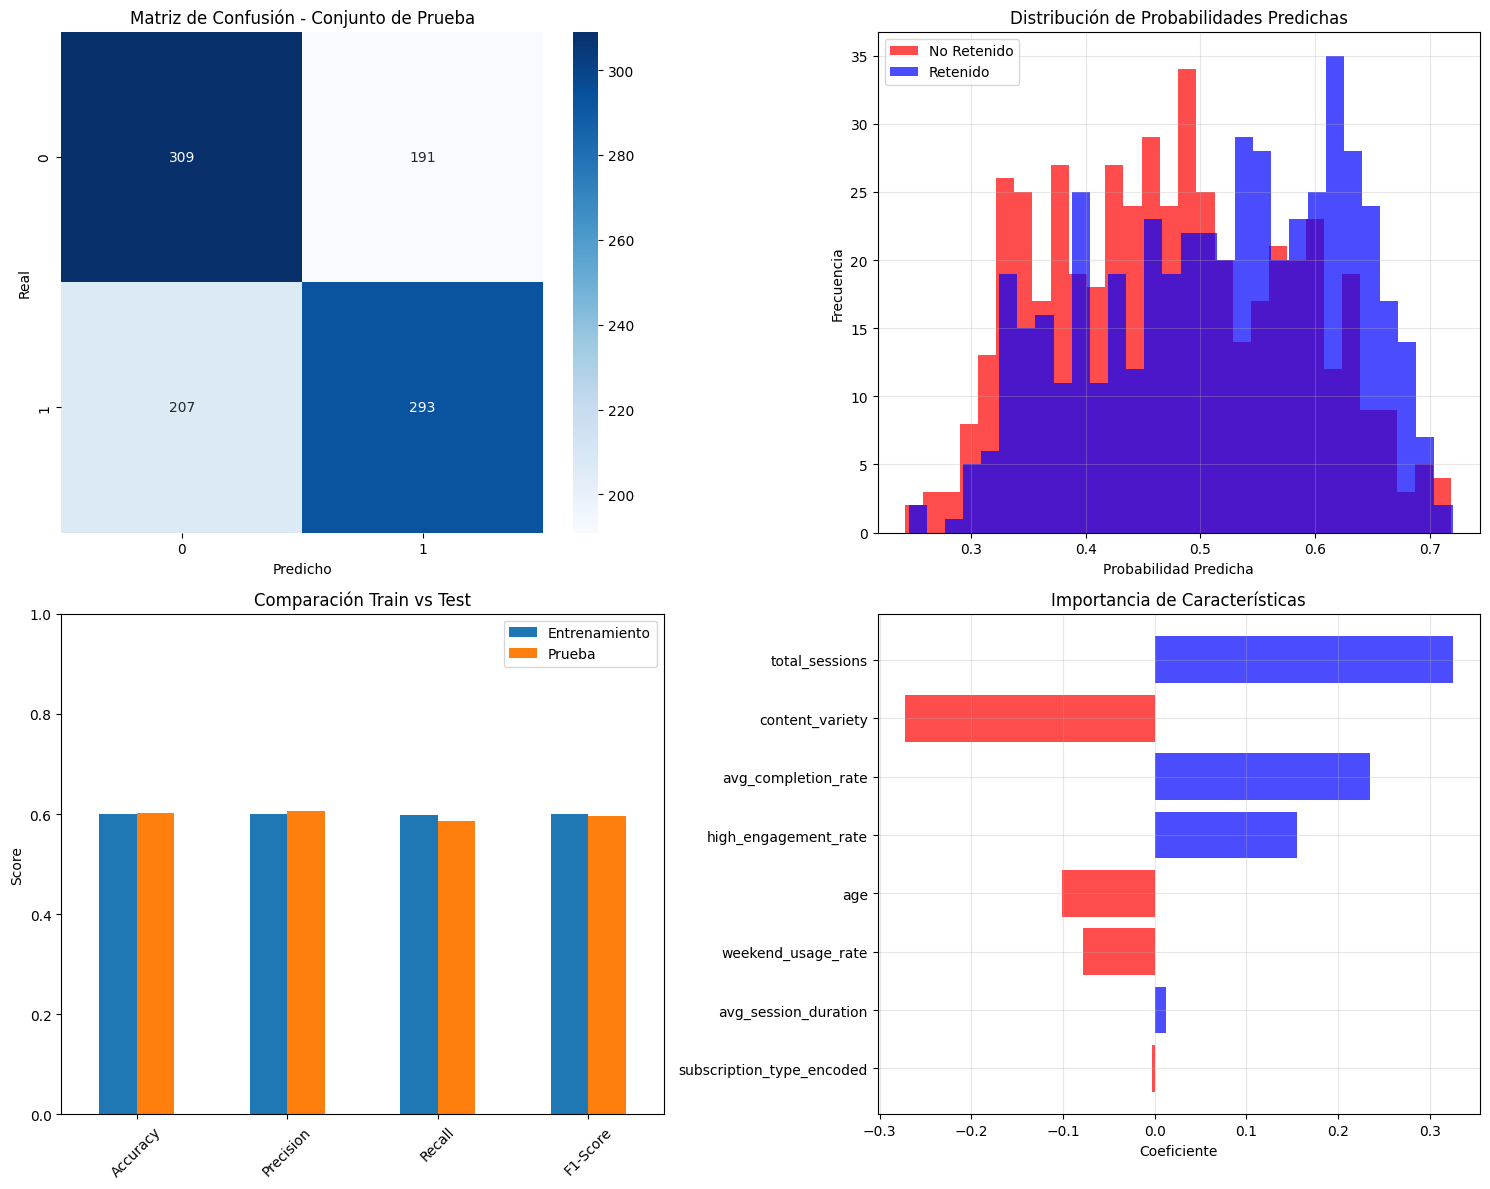


REPORTE DETALLADO DE CLASIFICACI√ìN:
              precision    recall  f1-score   support

 No Retenido       0.60      0.62      0.61       500
    Retenido       0.61      0.59      0.60       500

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



In [16]:
if 'logistic_model' in locals():
    print("EVALUACI√ìN COMPLETA DEL MODELO")
    print("="*60)
    
    # Evaluar en conjunto de entrenamiento
    train_eval = evaluate_model(y_train, y_pred_train, y_pred_proba_train, "ENTRENAMIENTO")
    
    print("\n")
    
    # Evaluar en conjunto de prueba
    test_eval = evaluate_model(y_test, y_pred_test, y_pred_proba_test, "PRUEBA")
    
    # Crear visualizaciones
    metrics_df = plot_model_evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_test)
    
    print(f"\nREPORTE DETALLADO DE CLASIFICACI√ìN:")
    print(classification_report(y_test, y_pred_test, target_names=['No Retenido', 'Retenido']))

## Interpretaci√≥n del Modelo

In [17]:
def interpret_model_results(model, feature_names, scaler, X_test, y_test):
    """
    Interpretar resultados del modelo y generar insights
    """
    print("INTERPRETACI√ìN DEL MODELO")
    print("="*50)
    
    # Coeficientes del modelo
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0],
        'Abs_Coefficient': np.abs(model.coef_[0]),
        'Odds_Ratio': np.exp(model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("COEFICIENTES E INTERPRETACI√ìN:")
    display(coefficients)
    
    print(f"\nINTERPRETACI√ìN DE COEFICIENTES:")
    for _, row in coefficients.iterrows():
        direction = "aumenta" if row['Coefficient'] > 0 else "disminuye"
        odds_interpretation = f"multiplica las odds por {row['Odds_Ratio']:.2f}" if row['Odds_Ratio'] != 1 else "no afecta las odds"
        
        print(f"   ‚Ä¢ {row['Feature']}:")
        print(f"     - Coeficiente: {row['Coefficient']:.3f}")
        print(f"     - {direction} la probabilidad de retenci√≥n")
        print(f"     - Odds Ratio: {odds_interpretation}")
    
    # Caracter√≠sticas m√°s importantes
    print(f"\nTOP 3 CARACTER√çSTICAS M√ÅS IMPORTANTES:")
    for i, (_, row) in enumerate(coefficients.head(3).iterrows(), 1):
        impact = "Positivo" if row['Coefficient'] > 0 else "Negativo"
        print(f"   {i}. {row['Feature']} (Impacto {impact})")
    
    # Intercept
    intercept = model.intercept_[0]
    baseline_odds = np.exp(intercept)
    baseline_prob = baseline_odds / (1 + baseline_odds)
    
    print(f"\nL√çNEA BASE DEL MODELO:")
    print(f"   ‚Ä¢ Intercept: {intercept:.3f}")
    print(f"   ‚Ä¢ Probabilidad base de retenci√≥n: {baseline_prob:.3f} ({baseline_prob*100:.1f}%)")
    
    return coefficients

# Interpretar modelo si est√° disponible
if 'logistic_model' in locals():
    model_interpretation = interpret_model_results(logistic_model, model_features, scaler_model, X_test, y_test)


INTERPRETACI√ìN DEL MODELO
COEFICIENTES E INTERPRETACI√ìN:


Feature  Coefficient  Abs_Coefficient  Odds_Ratio
1             total_sessions     0.325020         0.325020    1.384058
6            content_variety    -0.272305         0.272305    0.761622
3        avg_completion_rate     0.234714         0.234714    1.264547
4       high_engagement_rate     0.154942         0.154942    1.167591
0                        age    -0.101529         0.101529    0.903455
5         weekend_usage_rate    -0.078697         0.078697    0.924320
2       avg_session_duration     0.012655         0.012655    1.012735
7  subscription_type_encoded    -0.003247         0.003247    0.996758


INTERPRETACI√ìN DE COEFICIENTES:
   ‚Ä¢ total_sessions:
     - Coeficiente: 0.325
     - aumenta la probabilidad de retenci√≥n
     - Odds Ratio: multiplica las odds por 1.38
   ‚Ä¢ content_variety:
     - Coeficiente: -0.272
     - disminuye la probabilidad de retenci√≥n
     - Odds Ratio: multiplica las odds por 0.76
   ‚Ä¢ avg_completion_rate:
     - Coeficiente: 0.235
     - aumenta la probabilidad de retenci√≥n
     - Odds Ratio: multiplica las odds por 1.26
   ‚Ä¢ high_engagement_rate:
     - Coeficiente: 0.155
     - aumenta la probabilidad de retenci√≥n
     - Odds Ratio: multiplica las odds por 1.17
   ‚Ä¢ age:
     - Coeficiente: -0.102
     - disminuye la probabilidad de retenci√≥n
     - Odds Ratio: multiplica las odds por 0.90
   ‚Ä¢ weekend_usage_rate:
     - Coeficiente: -0.079
     - disminuye la probabilidad de retenci√≥n
     - Odds Ratio: multiplica las odds por 0.92
   ‚Ä¢ avg_session_duration:
     - Coeficiente: 0.013
     - aumenta la probabilidad de retenci√≥n


## Recomendaciones de Negocio

In [18]:
def generate_business_recommendations(cluster_interpretations, model_interpretation, test_eval):
    """
    Generar recomendaciones de negocio basadas en clustering y modelo predictivo
    """
    print("RECOMENDACIONES DE NEGOCIO")
    print("="*60)
    
    print("BASADAS EN SEGMENTACI√ìN DE USUARIOS (CLUSTERING):")
    print("-" * 50)
    
    if 'labels' in locals():
        # Recomendaciones por cluster
        for cluster_name, interpretation in cluster_interpretations.items():
            cluster_id = cluster_name.split('_')[1]
            label = labels.get(cluster_name, "Segmento de Usuarios")
            
            print(f"\nüî∏ {label}:")
            print(f"   üë• Tama√±o: {interpretation['size']:,} usuarios ({interpretation['percentage']:.1f}%)")
            
            # Estrategias espec√≠ficas basadas en caracter√≠sticas
            high_features = [c['feature'] for c in interpretation['characteristics'] if c['level'] == 'Alto']
            low_features = [c['feature'] for c in interpretation['characteristics'] if c['level'] == 'Bajo']
            
            strategies = []
            if 'total_watch_time_hours' in high_features:
                strategies.append("Programa de fidelizaci√≥n con beneficios exclusivos")
                strategies.append("Acceso temprano a contenido premium")
            
            if 'avg_completion_rate' in high_features:
                strategies.append("Recomendaciones de contenido de alta calidad")
                strategies.append("Alertas de nuevos episodios/temporadas")
            
            if 'age' in high_features:
                strategies.append("Contenido curado para audiencia madura")
                strategies.append("Interface simplificada y accesible")
            
            if 'total_sessions' in high_features:
                strategies.append("Funciones de continuidad mejoradas")
                strategies.append("Sincronizaci√≥n multi-dispositivo")
            
            if not strategies:
                strategies = ["Ofertas promocionales para incrementar engagement",
                            "Contenido popular y trending para atraer inter√©s"]
            
            print(f"   üí° Estrategias recomendadas:")
            for i, strategy in enumerate(strategies[:3], 1):
                print(f"      {i}. {strategy}")
    
    print(f"\nBASADAS EN MODELO PREDICTIVO:")
    print("-" * 50)
    
    if 'model_interpretation' in locals():
        # Factores m√°s importantes para retenci√≥n
        top_features = model_interpretation.head(3)
        
        print("FACTORES CLAVE PARA LA RETENCI√ìN:")
        for i, (_, feature) in enumerate(top_features.iterrows(), 1):
            impact_type = "Incrementar" if feature['Coefficient'] > 0 else "Optimizar"
            print(f"   {i}. {feature['Feature']} ({impact_type})")
            
            # Recomendaciones espec√≠ficas por caracter√≠stica
            if 'completion_rate' in feature['Feature']:
                print(f"      ‚Üí Mejorar calidad y relevancia del contenido")
                print(f"      ‚Üí Optimizar duraci√≥n de episodios/pel√≠culas")
            elif 'session' in feature['Feature']:
                print(f"      ‚Üí Facilitar el acceso a la plataforma")
                print(f"      ‚Üí Implementar notificaciones personalizadas")
            elif 'age' in feature['Feature']:
                print(f"      ‚Üí Personalizar experiencia por grupo etario")
                print(f"      ‚Üí Adaptar cat√°logo a preferencias demogr√°ficas")
    
    # M√©tricas del modelo para contexto
    if 'test_eval' in locals():
        print(f"\nCONFIABILIDAD DE LAS PREDICCIONES:")
        print(f"   ‚Ä¢ Exactitud del modelo: {test_eval['accuracy']:.1%}")
        print(f"   ‚Ä¢ Precisi√≥n: {test_eval['precision']:.1%}")
        print(f"   ‚Ä¢ Recall: {test_eval['recall']:.1%}")
    
    print(f"\nACCIONES PRIORITARIAS:")
    print("-" * 30)
    
    priority_actions = [
        "1. Implementar sistema de recomendaciones personalizado por cluster",
        "2. Desarrollar campa√±as de retenci√≥n dirigidas por segmento",
        "3. Optimizar caracter√≠sticas que m√°s impactan la retenci√≥n",
        "4. Monitorear m√©tricas de engagement por cluster mensualmente",
        "5. A/B testing de estrategias espec√≠ficas por segmento"
    ]
    
    for action in priority_actions:
        print(f"   {action}")
    
    print(f"\nM√âTRICAS DE SEGUIMIENTO RECOMENDADAS:")
    print("-" * 40)
    
    metrics = [
        "‚Ä¢ Tasa de retenci√≥n por cluster (mensual)",
        "‚Ä¢ Tiempo promedio de visualizaci√≥n por segmento",
        "‚Ä¢ Tasa de completion por tipo de contenido",
        "‚Ä¢ Engagement score por usuario",
        "‚Ä¢ ROI de campa√±as segmentadas"
    ]
    
    for metric in metrics:
        print(f"   {metric}")

# Generar recomendaciones
if 'interpretations' in locals() and 'model_interpretation' in locals():
    generate_business_recommendations(interpretations, model_interpretation, test_eval)



RECOMENDACIONES DE NEGOCIO
BASADAS EN SEGMENTACI√ìN DE USUARIOS (CLUSTERING):
--------------------------------------------------

BASADAS EN MODELO PREDICTIVO:
--------------------------------------------------
FACTORES CLAVE PARA LA RETENCI√ìN:
   1. total_sessions (Incrementar)
      ‚Üí Facilitar el acceso a la plataforma
      ‚Üí Implementar notificaciones personalizadas
   2. content_variety (Optimizar)
   3. avg_completion_rate (Incrementar)
      ‚Üí Mejorar calidad y relevancia del contenido
      ‚Üí Optimizar duraci√≥n de episodios/pel√≠culas

CONFIABILIDAD DE LAS PREDICCIONES:
   ‚Ä¢ Exactitud del modelo: 60.2%
   ‚Ä¢ Precisi√≥n: 60.5%
   ‚Ä¢ Recall: 58.6%

ACCIONES PRIORITARIAS:
------------------------------
   1. Implementar sistema de recomendaciones personalizado por cluster
   2. Desarrollar campa√±as de retenci√≥n dirigidas por segmento
   3. Optimizar caracter√≠sticas que m√°s impactan la retenci√≥n
   4. Monitorear m√©tricas de engagement por cluster mensualmente
 

In [19]:
print("RESUMEN - CLUSTERING Y MODELADO PREDICTIVO")
print("="*70)

summary_points = [
    "CLUSTERING (SEGMENTACI√ìN DE USUARIOS):",
    f"   ‚Ä¢ {optimal_k if 'optimal_k' in locals() else 'N'} clusters identificados usando K-means",
    f"   ‚Ä¢ Silhouette Score: {silhouette_scores[k_range.index(optimal_k)] if 'optimal_k' in locals() and optimal_k in k_range else 'N/A'}",
    "   ‚Ä¢ Cada cluster representa un segmento √∫nico de usuarios con comportamientos similares",
    "   ‚Ä¢ Perfiles detallados creados para estrategias de marketing dirigidas",
    "",
    "MODELO PREDICTIVO DE RETENCI√ìN:",
    f"   ‚Ä¢ Algoritmo: Regresi√≥n Log√≠stica",
    f"   ‚Ä¢ Accuracy: {test_eval['accuracy']:.1%} en conjunto de prueba" if 'test_eval' in locals() else "   ‚Ä¢ Accuracy: N/A",
    f"   ‚Ä¢ Precision: {test_eval['precision']:.1%}" if 'test_eval' in locals() else "   ‚Ä¢ Precision: N/A", 
    f"   ‚Ä¢ Recall: {test_eval['recall']:.1%}" if 'test_eval' in locals() else "   ‚Ä¢ Recall: N/A",
    "   ‚Ä¢ Variables m√°s importantes identificadas para retenci√≥n",
    "",
    "INSIGHTS PRINCIPALES:",
    "   ‚Ä¢ Usuarios segmentados exitosamente en grupos comportamentales",
    "   ‚Ä¢ Factores clave de retenci√≥n cuantificados y priorizados",
    "   ‚Ä¢ Estrategias espec√≠ficas desarrolladas por segmento",
    "   ‚Ä¢ Base s√≥lida para toma de decisiones basada en datos",
]

for point in summary_points:
    print(point)


# Guardar resultados finales
if 'clustered_data' in locals():
    # Guardar datos con clusters asignados
    final_user_data = user_metrics.merge(
        clustered_data[['user_id', 'cluster']] if 'user_id' in clustered_data.columns else 
        pd.DataFrame({'cluster': labels}, index=clustered_data.index), 
        left_index=True, right_index=True, how='left'
    )
    
    

RESUMEN - CLUSTERING Y MODELADO PREDICTIVO
CLUSTERING (SEGMENTACI√ìN DE USUARIOS):
   ‚Ä¢ 2 clusters identificados usando K-means
   ‚Ä¢ Silhouette Score: 0.24682221214291952
   ‚Ä¢ Cada cluster representa un segmento √∫nico de usuarios con comportamientos similares
   ‚Ä¢ Perfiles detallados creados para estrategias de marketing dirigidas

MODELO PREDICTIVO DE RETENCI√ìN:
   ‚Ä¢ Algoritmo: Regresi√≥n Log√≠stica
   ‚Ä¢ Accuracy: 60.2% en conjunto de prueba
   ‚Ä¢ Precision: 60.5%
   ‚Ä¢ Recall: 58.6%
   ‚Ä¢ Variables m√°s importantes identificadas para retenci√≥n

INSIGHTS PRINCIPALES:
   ‚Ä¢ Usuarios segmentados exitosamente en grupos comportamentales
   ‚Ä¢ Factores clave de retenci√≥n cuantificados y priorizados
   ‚Ä¢ Estrategias espec√≠ficas desarrolladas por segmento
   ‚Ä¢ Base s√≥lida para toma de decisiones basada en datos
